# Time Series Data

Resources
1. [ARIMA](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

2. [Time Series](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

3. [The complete guide to time series](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from scipy import signal

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/MatthewFried/Udemy/master/Data/Gas%20Prices.csv")
df.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


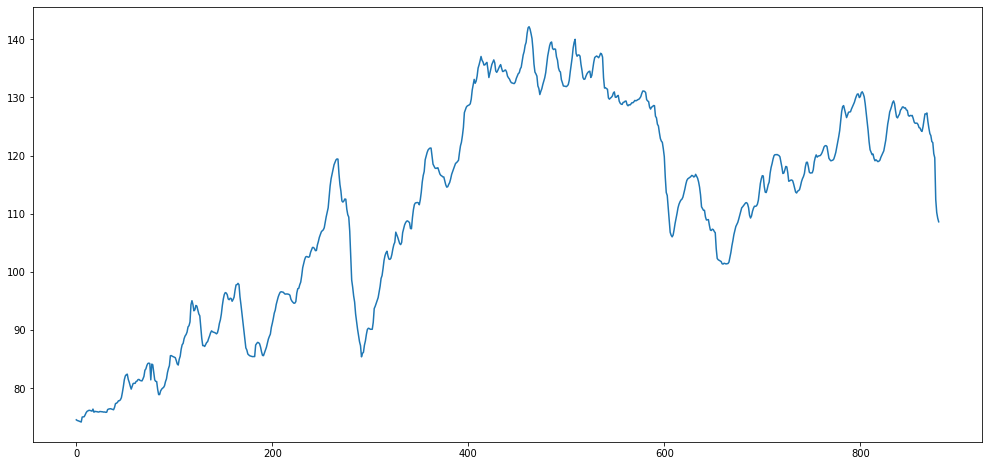

In [4]:
plt.figure(figsize=(17, 8))
plt.plot(df['Petrol (USD)'])
plt.show()

In [15]:
#import parse data in the right format
def parser(x):
	return pd.datetime.strptime(x, '%m/%d/%Y')
 
series = pd.read_csv("https://raw.githubusercontent.com/MatthewFried/Udemy/master/Data/Gas%20Prices.csv", header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


Date
2003-06-09    74.59
2003-06-16    74.47
2003-06-23    74.42
2003-06-30    74.35
2003-07-07    74.28
Name: Petrol (USD), dtype: float64

# Model 1

We test ARIMA.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  880
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -876.780
Method:                       css-mle   S.D. of innovations              0.655
Date:                Mon, 08 Nov 2021   AIC                           1767.561
Time:                        05:40:15   BIC                           1801.020
Sample:                             1   HQIC                          1780.356
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0338      0.069      0.489      0.625      -0.102       0.169
ar.L1.D.y      0.5922      0.034     17.581      0.000       0.526       0.658
ar.L2.D.y      0.0569      0.039      1.456      0.1

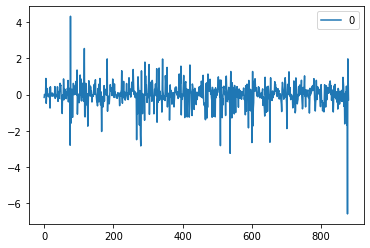

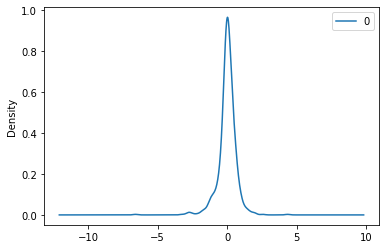

                0
count  880.000000
mean     0.000158
std      0.655521
min     -6.603569
25%     -0.213472
50%      0.021144
75%      0.293679
max      4.338367


In [18]:
#create ARIMA model after converting to numpy
model = ARIMA(np.asarray(series), order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Test ARIMA on training and testing data

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test RMSE: 0.683


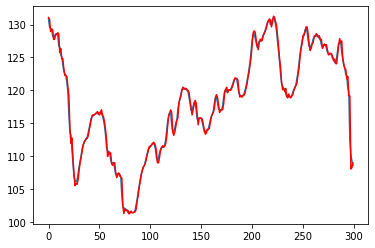

In [23]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Detrend and Check if Valuable Change

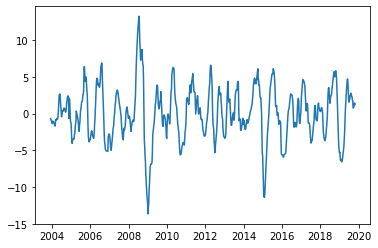

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

#we have weekly data, so we decompose to 52 days
df = pd.read_csv("https://raw.githubusercontent.com/MatthewFried/Udemy/master/Data/Gas%20Prices.csv")
result_mul = seasonal_decompose(series, model='multiplicative',freq = 52)
detrended = series - result_mul.trend
plt.plot(detrended)

# Deseasonalize

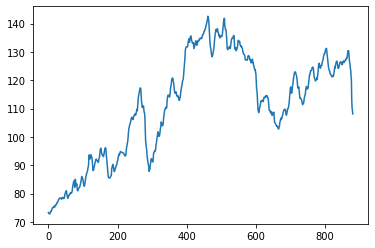

In [49]:
# Time Series Decomposition
result_mul = seasonal_decompose(df['Petrol (USD)'], model='multiplicative', extrapolate_trend='freq',freq= 52)

# Deseasonalize
deseasonalized = df['Petrol (USD)'] / result_mul.seasonal

# Plot
plt.plot(deseasonalized)

We see that deseasonalizing it doesn't change much, so perhaps it isn't seasonal.

# Model 2

Run exponential smooth model

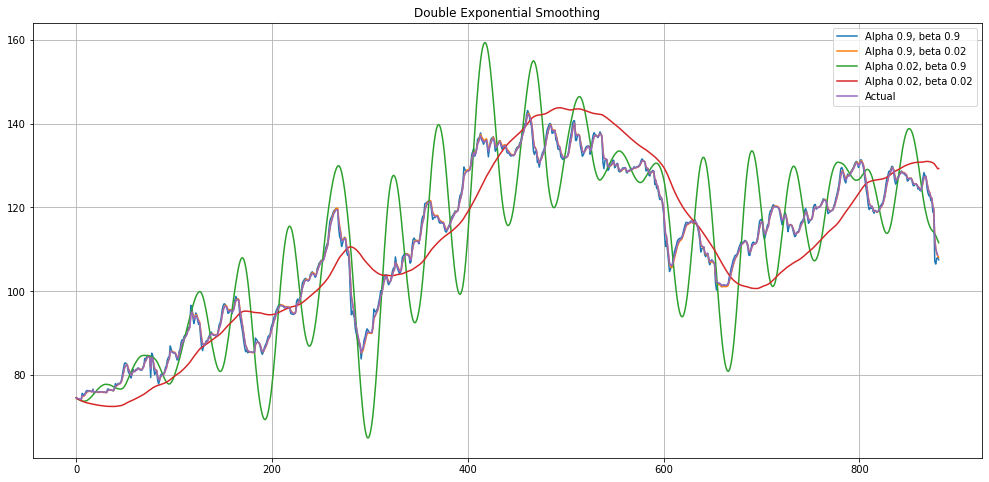

In [51]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df['Petrol (USD)'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Model 3

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test RMSE: 0.681


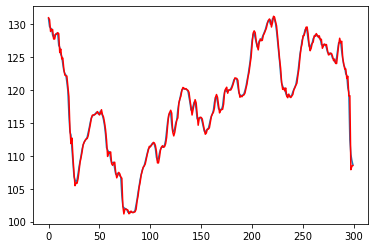

In [53]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

We ran three models. The first used an ARIMA(5,1,0) which had very similar RMSE to ARMA(2,1,0).  The middle model, a exponential smoothing as the best fit, but it may be overfitting the data and therefore not useful in the future.